In [1]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip uninstall -y torchvision

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import warnings
from IPython.display import display
import os
import sys
import kaleido
import plotly
import pandas as pd
import pickle
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pandas._libs.tslibs.parsing import DateParseError
import matplotlib.pyplot as plt
import seaborn as sns
#import functions.gui
from dateutil.relativedelta import relativedelta
import functions.GrangerCausality
import functions.NP_model
import functions.settings
functions.settings.init() 
import matplotlib

In [331]:
functions.settings.current_wd = os.getcwd()

## Parametros

In [530]:
#Año
anio = '2025'
#Trimestre
tetra= '3T'
#Banco
banco = 'Banregio/' #Con la diagonal para las rutas

#Variables para filtro de cartera y etapa
segmento = 'Menores' 
etapa = 2

#Nombre del proyecto
functions.settings.project_name = f'Menores E{etapa}'

#Ruta archivo inicial
RUTA_HISTORICO = 's3://boi-banregio/datalake/data/InteligenciaRiesgos/brm17632/RiesgoCredito/ESC/'+anio+'/'+tetra+'/'+banco+'PI_Hist_Por_Etapas.csv'
#Columnas de fecha y sobre la que se hara la prediccion
col_fecha = 'aniomes'
col_pred = 'PI'

#Ruta VarsEco_Base
RUTA_ESC_BASE = 's3://boi-banregio/datalake/data/InteligenciaRiesgos/brm17632/RiesgoCredito/ESC/'+anio+'/'+tetra+'/'+banco+'VarsEco_Base.csv'

#Ruta VarsEco_Adverso
RUTA_ESC_ADV = 's3://boi-banregio/datalake/data/InteligenciaRiesgos/brm17632/RiesgoCredito/ESC/'+anio+'/'+tetra+'/'+banco+'VarsEco_Adverso.csv'

#Fecha de corte entrenamiento
fecha_train = '202408'

#Lista de eventos
try:
    with open(f'{functions.settings.current_wd}/Proyectos/{banco}{functions.settings.project_name}/time_events.pkl', 'rb') as f:
        events = pickle.load(f)
except FileNotFoundError as e:
    print("No se encontro un archivo guardado para los eventos, se usaran los de abajo")
    events = [
                {
                    "ds": pd.date_range(start='2020-03-01', end='2021-12-31', freq='MS'), #ajustar fecha de inicio y fin
                    'covid': 1  #cambiar nombre del evento, el 1 se mantiene como valor
                },
                {
                    "ds": pd.date_range(start='2024-01-01', end='2024-12-31', freq='MS'), #ajustar fecha de inicio y fin
                    'cartera_banregio': 1  #cambiar nombre del evento, el 1 se mantiene como valor
                }
            ]

In [531]:
if functions.settings.project_name is not None:
    functions.settings.create_dir(banco)
    print(functions.settings.project_name)
else:
    print("No input received.")
    sys.exit()

Menores E2


## Lectura de bases

In [532]:
def read_file_to_dataframe(path):
    ext = os.path.splitext(path)[1].lower()
    if ext == ".csv":
        return pd.read_csv(path)
    elif ext in [".xls", ".xlsx"]:
        return pd.read_excel(path)
    else:
        raise ValueError(f"Unsupported file type: {ext}")

In [533]:
df = read_file_to_dataframe(RUTA_HISTORICO)
df=df[['aniomes','Etapa','Sgmt_ESC','PI']]
df['Sgmt_ESC'] = df['Sgmt_ESC'].replace('Vivienda', 'Hipotecario') #Ajustamos el nombre del segmento vivienda
df = df[(df['Etapa'] == etapa) & (df['Sgmt_ESC'] == segmento)] #Filtramos la cartera y etapa que se va a modelar

VarsEco_Base = read_file_to_dataframe(RUTA_ESC_BASE)

VarsEco_Adv = read_file_to_dataframe(RUTA_ESC_ADV)

In [534]:
#Definimos columnas de añomes como strings
df[col_fecha] = df[col_fecha].astype(str)
if len(df[col_fecha].max()) != 6:
    try:
        df['aniomes'] = pd.to_datetime(df[col_fecha]).dt.strftime('%Y%m')
    except DateParseError as e:
        print("Error: Revisar el formato de la columna de fecha. Asegurar que venga en formato de añomes(AAAAMM) o de fecha-hora.")
        sys.exit()
        
VarsEco_Base['aniomes'] = VarsEco_Base['aniomes'].astype(str)
VarsEco_Adv['aniomes'] = VarsEco_Adv['aniomes'].astype(str)
fecha_real = df['aniomes'].max()

Eco_Base = VarsEco_Base[VarsEco_Base['aniomes']<= fecha_real]
Eco_Base.head()

Eco_Adv = VarsEco_Adv[VarsEco_Adv['aniomes']<= fecha_real]
Eco_Adv.head()

same = (Eco_Base.columns==Eco_Adv.columns).all()
if same:
    print("The column names have the same order.")
else:
    print("The column names do not have the same order.")
    sys.exit()

Bs_Hist = df.merge(Eco_Base, how='left', on='aniomes')

The column names have the same order.


In [535]:
 # Rename the selected columns
Bs_Hist.rename(columns={'aniomes':'ds'},inplace=True)
Bs_Hist.rename(columns={col_pred:'y'},inplace=True)
Bs_Hist['ds']=(Bs_Hist['ds'].astype(str).str[0:4])+'-'+(Bs_Hist['ds'].astype(str).str[4:6])+'-'+'01'
Bs_Hist['ds']=pd.to_datetime(Bs_Hist['ds'])

In [536]:
# Additional variables to include in all DataFrames
additional_vars = ['Fondeo1dia', 'Cetes28', 'Cetes91', 'Cetes182', 'Cetes364', 
                'BonoM3', 'BonoM5', 'BonoM10', 'TasaFedEUA', 'Tbill1m', 'Tbill3m', 
                'Tbill6m', 'Tbill12m', 'Tnote3A', 'Tnote5A', 'Tnote10A', 'InflacionAn', 
                'MXNaUSD', 'USDaEUR', 'CambioPIB_anual', 'Desempleo', 'IPC', 
                'SyP', 'ExpNoPetro', 'VIX_BMV', 'VIX_USA']

df_inicial = Bs_Hist[['ds', 'y'] + additional_vars].reset_index(drop=True).copy()


if fecha_train is not None:
    print(f"You entered: {fecha_train}")
else:
    print("No value entered.")
    sys.exit()

#Formateo de fecha de entrenamiento añomes --> AAAA-MM-DD
date_train = datetime.strptime(str(fecha_train),"%Y%m")
date_train = datetime.strftime(date_train,"%Y-%m-01")
date_train = pd.to_datetime(date_train)

df_train = df_inicial[df_inicial['ds']<= date_train]
df_train.tail()

You entered: 202408


,ds,y,Fondeo1dia,Cetes28,Cetes91,Cetes182,Cetes364,BonoM3,BonoM5,BonoM10,...,InflacionAn,MXNaUSD,USDaEUR,CambioPIB_anual,Desempleo,IPC,SyP,ExpNoPetro,VIX_BMV,VIX_USA
74,2024-04-01,0.307318,0.111400,0.110033,0.111633,0.112167,0.112167,0.101967,0.095500,0.093467,...,0.046067,0.017147,0.010767,0.031767,0.027000,0.055726,0.053227,0.046735,0.013177,0.01282
75,2024-05-01,0.453505,0.110700,0.109867,0.111467,0.112233,0.113033,0.105133,0.098500,0.094933,...,0.047933,0.017733,0.010733,0.031933,0.027200,0.054083,0.053913,0.048112,0.011723,0.01263
76,2024-06-01,0.517420,0.110000,0.109700,0.111300,0.112300,0.113900,0.108300,0.101500,0.096400,...,0.049800,0.018320,0.010700,0.032100,0.027400,0.052440,0.054600,0.049488,0.010270,0.01244
77,2024-07-01,0.428403,0.108167,0.108100,0.109700,0.110600,0.111667,0.103967,0.099367,0.095967,...,0.049200,0.018627,0.010833,0.031960,0.028133,0.052766,0.055653,0.050226,0.009817,0.01387
78,2024-08-01,0.404006,0.106333,0.106500,0.108100,0.108900,0.109433,0.099633,0.097233,0.095533,...,0.048600,0.018933,0.010967,0.031820,0.028867,0.053093,0.056707,0.050964,0.009363,0.01530


## Revision de grafica para eventos

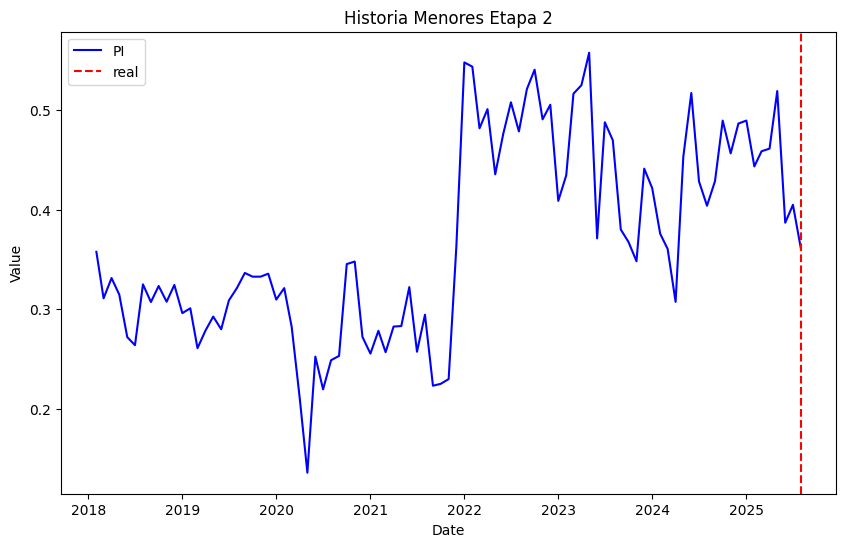

In [537]:
#Graficar cartera
fig = plt.figure(figsize=(10, 6))
plt.plot(Bs_Hist['ds'], Bs_Hist['y'], label='PI', color='blue')

plt.axvline(x=pd.to_datetime('2025-08-01'), color='red', linestyle='--', label='real')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title(f'Historia {segmento} Etapa {etapa}')
plt.legend()
plt.show()

## Pruebas de Granger

In [12]:
def apply_granger_causality(df_inicial, df_train):
    
    stationary_info = functions.GrangerCausality.make_series_stationary(df_train)

    # Create a new DataFrame with differenced variables
    differenced_df = functions.GrangerCausality.make_differenced_dataframe(df_train, stationary_info)


    # Perform Granger causality test with automatic lag selection based on SSR Chi-Square test
    granger_results = functions.GrangerCausality.granger_causality_test(differenced_df, 'y', test='ssr_chi2test')

    #print("Granger Causality Test Results using SSR Chi-Square Test:")
    for variable, result in granger_results.items():
        print(f"{variable}: p-value = {result['p_value']}, Best Lag = {result['best_lag']}")

    # Extract significant variables and their p-values
    significant_variables = [(variable, result['p_value']) for variable, result in granger_results.items() if result['p_value'] <= 0.05]

    # Create a DataFrame from the list
    tabla1=pd.DataFrame(significant_variables, columns=['Variable', 'p-value'])

    # Print the results
    print("Significant Variables (p-value <= 0.05):")
    for variable, p_value in significant_variables:
        print(f"{variable}: p-value = {p_value}")

    # Extract significant variables as a list
    significant_variables = [variable for variable, result in granger_results.items() if result['p_value'] <= 0.05]
    future_regressor=significant_variables
    #future_regressor
    #Guardamos las variables con significancia
    functions.NP_model.save_regressors('granger_results', future_regressor, banco)

    df_red=df_inicial[['ds','y'] + future_regressor]

    return df_red, future_regressor, granger_results

In [13]:
df_red, future_regressor, granger_results = apply_granger_causality(df_inicial, df_train)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4167  , p=0.2417  , df_denom=36, df_num=1
ssr based chi2 test:   chi2=1.5348  , p=0.2154  , df=1
likelihood ratio test: chi2=1.5053  , p=0.2199  , df=1
parameter F test:         F=1.4167  , p=0.2417  , df_denom=36, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4167  , p=0.2417  , df_denom=36, df_num=1
ssr based chi2 test:   chi2=1.5348  , p=0.2154  , df=1
likelihood ratio test: chi2=1.5053  , p=0.2199  , df=1
parameter F test:         F=1.4167  , p=0.2417  , df_denom=36, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3551  , p=0.1106  , df_denom=33, df_num=2
ssr based chi2 test:   chi2=5.4240  , p=0.0664  , df=2
likelihood ratio test: chi2=5.0702  , p=0.0793  , df=2
parameter F test:         F=2.3551  , p=0.1106  , df_denom=33, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4167  , p=0.2417  , df_d

In [14]:
train_end_date = date_train
test_start_date = train_end_date + pd.DateOffset(months=1)

fecha_real_formato = datetime.strptime(str(fecha_real),"%Y%m")
fecha_real_formato = datetime.strftime(fecha_real_formato,"%Y-%m-01")
fecha_real_formato = pd.to_datetime(fecha_real_formato)

rel = relativedelta(train_end_date, fecha_real_formato)
forecast = int(abs(rel.years * 12 + rel.months))

basic=df_red[['ds','y']+ future_regressor]

In [15]:
future_regressor

['Fondeo1dia',
 'Cetes91',
 'Cetes182',
 'Cetes364',
 'BonoM3',
 'BonoM5',
 'BonoM10',
 'TasaFedEUA',
 'Tbill1m',
 'Tbill3m',
 'Tbill6m',
 'Tbill12m',
 'Tnote3A',
 'Tnote5A',
 'Tnote10A',
 'InflacionAn',
 'MXNaUSD',
 'Desempleo',
 'IPC',
 'SyP',
 'ExpNoPetro',
 'VIX_BMV',
 'VIX_USA']

## Entrenamiento

In [16]:
added_events = []

for ev in events:
    df_event = pd.DataFrame(
            ev
        )
    event_name = df_event.columns[1]
    added_events.append(event_name)

    # Merge the event variable with your existing DataFrame
    basic = pd.merge(basic, df_event, on='ds', how='left')
    # Set value to 0 for dates outside the range
    basic[event_name] = basic[event_name].fillna(0)
    basic[basic[event_name]==1.0]
    
# Filter the data based on the cutoff date
df_train = basic[basic['ds'] < test_start_date]
df_test = basic[basic['ds'] >= test_start_date]

next_months_df= basic[basic['ds'] >= test_start_date]
next_months_df=next_months_df[['ds']+ future_regressor + added_events]
next_months_df['y']=None
next_months_df=next_months_df[['ds','y']+ future_regressor + added_events]
df_train_f=pd.concat([df_train,next_months_df],ignore_index=True)

lr = functions.NP_model.find_best_lr(basic, test_start_date, forecast, future_regressor, added_events)

WARNING - (py.warnings._showwarnmsg) - /var/folders/x_/p6ykz6vs43zcbk31gc41v4440000gp/T/ipykernel_7075/3377660982.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_train_f=pd.concat([df_train,next_months_df],ignore_index=True)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /var/folders/x_/p6ykz6vs43zcbk31gc41v4440000gp/T/ipykernel_7075/3377660982.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_train_f=pd.concat([df_train,next_months_df],ignore_index=True)

WARNING - 

Resuming from: 0.002
Epoch 350: 100%|██████████| 350/350 [00:00<00:00, 21517.45it/s, loss=0.00432, v_num=305, MAE_val=0.00164, RMSE_val=0.00194, Loss_val=0.0265, RegLoss_val=0.000, MAE=0.00076, RMSE=0.000905, Loss=0.00422, RegLoss=0.000]   


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/functions/NP_model.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test_forecast_all = pd.concat([df_train, next_months_df], ignore_index=True)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/functions/NP_model.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test_forecast_all = pd.concat([df_train, next_months_df], ignore_index=True)

WARNIN

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 434.96it/s]


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select 

Progress saved. Last processed lr: 0.08.


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternati

Epoch 350: 100%|██████████| 350/350 [00:00<00:00, 21514.61it/s, loss=0.00457, v_num=306, MAE_val=0.00169, RMSE_val=0.00187, Loss_val=0.0246, RegLoss_val=0.000, MAE=0.000787, RMSE=0.00093, Loss=0.00443, RegLoss=0.000]   


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/functions/NP_model.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test_forecast_all = pd.concat([df_train, next_months_df], ignore_index=True)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/functions/NP_model.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test_forecast_all = pd.concat([df_train, next_months_df], ignore_index=True)

WARNIN

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 393.24it/s]


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select 

Progress saved. Last processed lr: 0.06.


WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``as

Epoch 350: 100%|██████████| 350/350 [00:00<00:00, 20521.80it/s, loss=0.00505, v_num=307, MAE_val=0.00181, RMSE_val=0.00205, Loss_val=0.0295, RegLoss_val=0.000, MAE=0.000834, RMSE=0.000985, Loss=0.00497, RegLoss=0.000]  


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/functions/NP_model.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test_forecast_all = pd.concat([df_train, next_months_df], ignore_index=True)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/functions/NP_model.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test_forecast_all = pd.concat([df_train, next_months_df], ignore_index=True)

WARNIN

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 387.14it/s]


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select 

Progress saved. Last processed lr: 0.04.


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternati

Epoch 350: 100%|██████████| 350/350 [00:00<00:00, 21491.93it/s, loss=0.00598, v_num=308, MAE_val=0.00205, RMSE_val=0.00218, Loss_val=0.0334, RegLoss_val=0.000, MAE=0.000911, RMSE=0.00107, Loss=0.0058, RegLoss=0.000]    


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/functions/NP_model.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test_forecast_all = pd.concat([df_train, next_months_df], ignore_index=True)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/functions/NP_model.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test_forecast_all = pd.concat([df_train, next_months_df], ignore_index=True)

WARNIN

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 415.28it/s]


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select 

Progress saved. Last processed lr: 0.02.


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternati

Epoch 350: 100%|██████████| 350/350 [00:00<00:00, 20876.68it/s, loss=0.01, v_num=309, MAE_val=0.00161, RMSE_val=0.00204, Loss_val=0.0291, RegLoss_val=0.000, MAE=0.0012, RMSE=0.00147, Loss=0.0105, RegLoss=0.000]        


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/functions/NP_model.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test_forecast_all = pd.concat([df_train, next_months_df], ignore_index=True)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/functions/NP_model.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test_forecast_all = pd.concat([df_train, next_months_df], ignore_index=True)

WARNIN

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 415.98it/s]


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select 

Progress saved. Last processed lr: 0.008.


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternati

Epoch 350: 100%|██████████| 350/350 [00:00<00:00, 21534.49it/s, loss=0.013, v_num=310, MAE_val=0.00171, RMSE_val=0.00209, Loss_val=0.0307, RegLoss_val=0.000, MAE=0.00137, RMSE=0.00171, Loss=0.0141, RegLoss=0.000]   


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/functions/NP_model.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test_forecast_all = pd.concat([df_train, next_months_df], ignore_index=True)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/functions/NP_model.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test_forecast_all = pd.concat([df_train, next_months_df], ignore_index=True)

WARNIN

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 403.73it/s]


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select 

Progress saved. Last processed lr: 0.006.


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternati

Epoch 350: 100%|██████████| 350/350 [00:00<00:00, 21655.53it/s, loss=0.0182, v_num=311, MAE_val=0.00185, RMSE_val=0.00233, Loss_val=0.0383, RegLoss_val=0.000, MAE=0.00163, RMSE=0.00209, Loss=0.0206, RegLoss=0.000]  


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/functions/NP_model.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test_forecast_all = pd.concat([df_train, next_months_df], ignore_index=True)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/functions/NP_model.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test_forecast_all = pd.concat([df_train, next_months_df], ignore_index=True)

WARNIN

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 411.00it/s]


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select 

Progress saved. Last processed lr: 0.004.


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternati

Epoch 350: 100%|██████████| 350/350 [00:00<00:00, 21865.51it/s, loss=0.0385, v_num=312, MAE_val=0.00271, RMSE_val=0.00314, Loss_val=0.0693, RegLoss_val=0.000, MAE=0.00244, RMSE=0.00301, Loss=0.0432, RegLoss=0.000]  


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/functions/NP_model.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test_forecast_all = pd.concat([df_train, next_months_df], ignore_index=True)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/functions/NP_model.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test_forecast_all = pd.concat([df_train, next_months_df], ignore_index=True)

WARNIN

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 429.22it/s]
Progress saved. Last processed lr: 0.002.
Best MAE with all variables: 0.0016103815287351608
Best Learning Rate for all variables: 0.008
Best MAE Error: 0.0016103817016514279
Best Learning Rate for MAE Error: 0.008
Metrics have been saved to metrics_lr.csv


In [17]:
# Split the dataset into train and test sets
df_train = basic[basic['ds'] < test_start_date].copy()
df_test = basic[basic['ds'] >= test_start_date].copy()

#Evaluates and saves all errors to a single CSV file for later analysis
functions.NP_model.regressor_error(basic, df_train, df_test, lr, test_start_date, forecast, future_regressor, added_events)

Resuming from: VIX_USA


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select 

 variable: Fondeo1dia
 variable: Cetes91
 variable: Cetes182
 variable: Cetes364
 variable: BonoM3
 variable: BonoM5
 variable: BonoM10
 variable: TasaFedEUA
 variable: Tbill1m
 variable: Tbill3m
 variable: Tbill6m
 variable: Tbill12m
 variable: Tnote3A
 variable: Tnote5A
 variable: Tnote10A
 variable: InflacionAn
 variable: MXNaUSD
 variable: Desempleo
 variable: IPC
 variable: SyP
 variable: ExpNoPetro
 variable: VIX_BMV
 variable: VIX_USA


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternati

Epoch 350: 100%|██████████| 350/350 [00:00<00:00, 21139.12it/s, loss=0.01, v_num=313, MAE_val=0.00161, RMSE_val=0.00204, Loss_val=0.0291, RegLoss_val=0.000, MAE=0.0012, RMSE=0.00147, Loss=0.0105, RegLoss=0.000]        


WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/functions/NP_model.py:281: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test_forecast_all = pd.concat([df_train, next_months_df], ignore_index=True)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/functions/NP_model.py:281: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test_forecast_all = pd.concat([df_train, next_months_df], ignore_index=True)

WARN

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 376.95it/s]


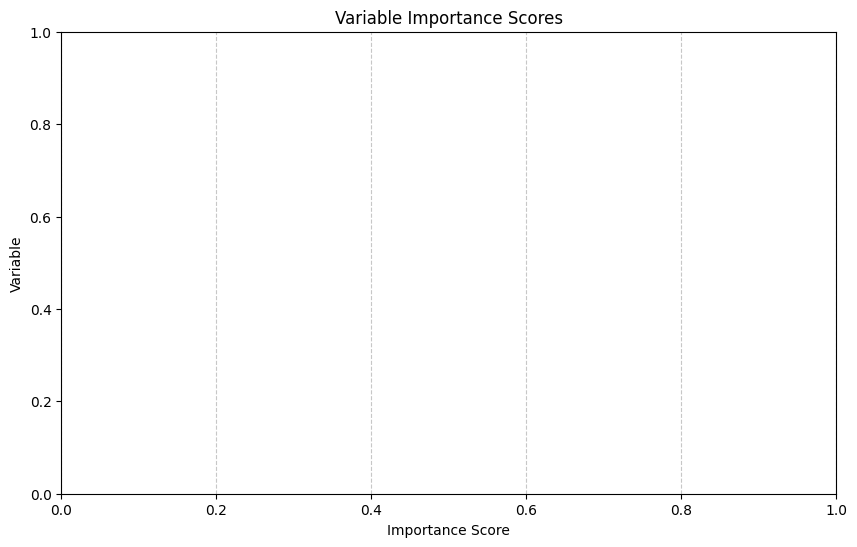

In [18]:
#Model training
importance_scores = functions.NP_model.get_importance_scores(basic, df_train, df_test, lr, test_start_date, forecast, future_regressor, added_events)

# Prepare data for plotting
variables = [var for var, score in importance_scores]
scores = [score for var, score in importance_scores]

# Create a DataFrame for seaborn
df_importance = pd.DataFrame({'Variable': variables, 'Importance Score': scores})

# Create a horizontal bar plot
fig = plt.figure(figsize=(10, 6))
sns.barplot(x='Importance Score', y='Variable', data=df_importance, palette='viridis')
plt.xlabel('Importance Score')
plt.ylabel('Variable')
plt.title('Variable Importance Scores')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()
fig.savefig(f'{functions.settings.current_wd}/Proyectos/{banco}{functions.settings.project_name}/Output/Importance_Scores.png', dpi=fig.dpi)

WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():



 variable: Fondeo1dia
 variable: Cetes91
 variable: Cetes182
 variable: Cetes364
 variable: BonoM3
 variable: BonoM5
 variable: BonoM10
 variable: TasaFedEUA
 variable: Tbill1m
 variable: Tbill3m
 variable: Tbill6m
 variable: Tbill12m
 variable: Tnote3A
 variable: Tnote5A
 variable: Tnote10A
 variable: InflacionAn
 variable: MXNaUSD
 variable: Desempleo
 variable: IPC
 variable: SyP
 variable: ExpNoPetro
 variable: VIX_BMV
 variable: VIX_USA


WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Use

Epoch 350: 100%|██████████| 350/350 [00:00<00:00, 19235.14it/s, loss=0.01, v_num=314, MAE_val=0.00161, RMSE_val=0.00204, Loss_val=0.0291, RegLoss_val=0.000, MAE=0.0012, RMSE=0.00147, Loss=0.0105, RegLoss=0.000]        


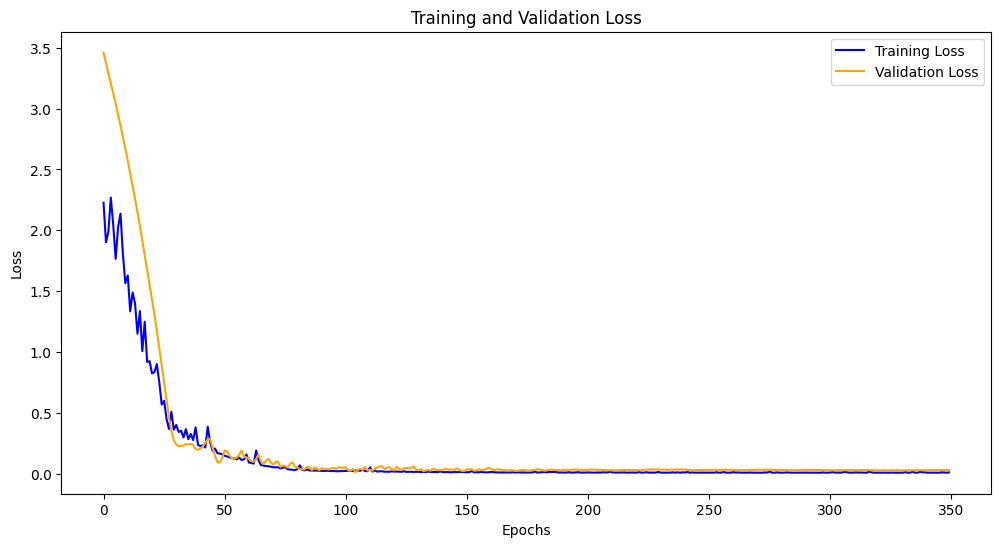

In [19]:

#Model training
m, metrics = functions.NP_model.train_model(df_train, df_test, lr, forecast, future_regressor, added_events)


# Create a larger figure
fig = plt.figure(figsize=(12, 6))
# Plot training loss curve
plt.plot(metrics['Loss'], label='Training Loss', color='blue')
# Plot validation loss curve
plt.plot(metrics['Loss_val'], label='Validation Loss', color='orange')
# Add labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
# Show the plot
plt.show()
fig.savefig(f'{functions.settings.current_wd}/Proyectos/{banco}{functions.settings.project_name}/Output/Model_Loss.png', dpi=fig.dpi)


#m.plot_parameters().savefig('Model_Parameters.png')

In [20]:
for variable, result in granger_results.items():
    if variable in future_regressor:
        print(f"{variable}: Best Lag = {result['best_lag']}")

df_train_forecast=m.predict(df_train_f)
# Visualize the forecast
#m.plot(df_train_forecast)

WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternati

Fondeo1dia: Best Lag = 4
Cetes91: Best Lag = 9
Cetes182: Best Lag = 7
Cetes364: Best Lag = 9
BonoM3: Best Lag = 4
BonoM5: Best Lag = 4
BonoM10: Best Lag = 4
TasaFedEUA: Best Lag = 4
Tbill1m: Best Lag = 9
Tbill3m: Best Lag = 4
Tbill6m: Best Lag = 4
Tbill12m: Best Lag = 4
Tnote3A: Best Lag = 9
Tnote5A: Best Lag = 9
Tnote10A: Best Lag = 9
InflacionAn: Best Lag = 2
MXNaUSD: Best Lag = 9
Desempleo: Best Lag = 7
IPC: Best Lag = 7
SyP: Best Lag = 4
ExpNoPetro: Best Lag = 9
VIX_BMV: Best Lag = 9
VIX_USA: Best Lag = 5


WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING	Task(Task-2) py.warnings:warnings.py:_showwarnmsg()- /Users/andre.rodriguez/Documents/Git/ir-ESC/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``as

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 397.94it/s]


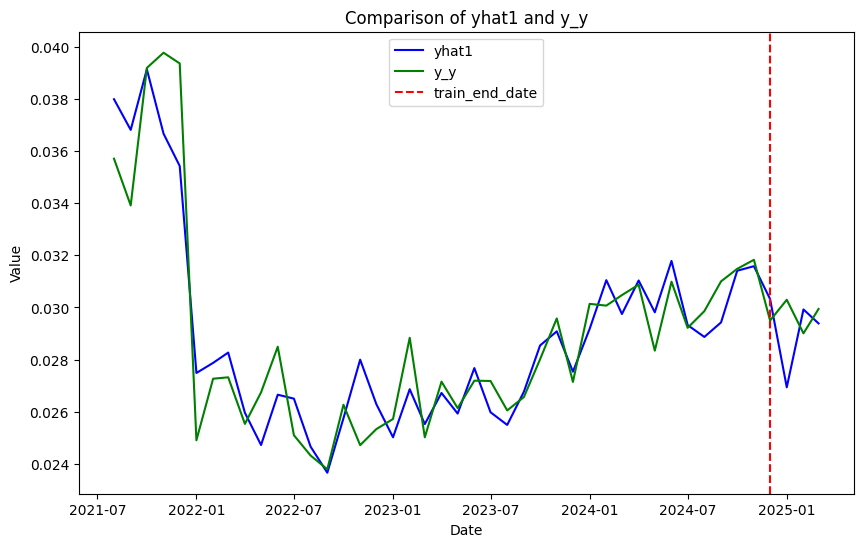

In [21]:
dd= df_train_forecast.merge(basic[['ds','y']], left_on='ds', right_on='ds', how='outer')
dd[['ds','y_y','yhat1']].tail(forecast+1)
# Extract 'ds', 'yhat1', and 'y_y' columns from the DataFrame
ds = dd['ds']
yhat1 = dd['yhat1']
y_y = dd['y_y']

# Plot the data
fig = plt.figure(figsize=(10, 6))
plt.plot(ds, yhat1, label='yhat1', color='blue')
plt.plot(ds, y_y, label='y_y', color='green')
plt.axvline(x=train_end_date, color='red', linestyle='--', label='train_end_date')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Comparison of yhat1 and y_y')
plt.legend()
plt.show()
fig.savefig(f'{functions.settings.current_wd}/Proyectos/{banco}{functions.settings.project_name}/Output/Comparacion_training.png', dpi=fig.dpi)

In [22]:
#Guardamos el modelo entrenado
functions.NP_model.save_model_attributes(forecast, lr, banco)

#Guardamos los regresores
functions.NP_model.save_regressors('future_regressors', future_regressor, banco)

#Guardamos los eventos
functions.NP_model.save_events('time_events', events, banco)

El modelo se ha guardado correctamente
Los regresores seleccionados se han guardado correctamente
Los eventos ingresados se han guardado correctamente


## Inferencia

In [538]:
#Leemos los archivos guardados previamente para el proyecto
with open(f'{functions.settings.current_wd}/Proyectos/{banco}{functions.settings.project_name}/modelo_{functions.settings.project_name}.pkl', 'rb') as f:
    model_attributes = pickle.load(f)

with open(f'{functions.settings.current_wd}/Proyectos/{banco}{functions.settings.project_name}/future_regressors.pkl', 'rb') as f:
    future_regressor = pickle.load(f)

with open(f'{functions.settings.current_wd}/Proyectos/{banco}{functions.settings.project_name}/granger_results.pkl', 'rb') as f:
    significant_variables = pickle.load(f)

with open(f'{functions.settings.current_wd}/Proyectos/{banco}{functions.settings.project_name}/time_events.pkl', 'rb') as f:
    events = pickle.load(f)

In [539]:
[item for item in significant_variables if item not in future_regressor]

[]

### Seleccion de variables para el pronostico, solo correr al hacer pruebas con las variables

In [545]:
significant_variables

['Fondeo1dia',
 'Cetes364',
 'BonoM3',
 'BonoM5',
 'BonoM10',
 'TasaFedEUA',
 'Tbill1m',
 'Tbill3m',
 'Tbill6m',
 'Tbill12m',
 'Tnote3A',
 'Tnote5A',
 'Tnote10A',
 'InflacionAn',
 'MXNaUSD',
 'CambioPIB_anual',
 'IPC',
 'SyP']

#### Copiar los resultados de la celda anterior y comentar las variables que no se quieran incluir

In [697]:
future_regressor = [
 #'Fondeo1dia',
 #'Cetes364',
 'BonoM3',
 'BonoM5',
 #'BonoM10',
 #'TasaFedEUA',
 'Tbill1m',
 'Tbill3m',
 'Tbill6m',
 'Tbill12m',
 #'Tnote3A',
 'Tnote5A',
 'Tnote10A',
 'InflacionAn',
 'MXNaUSD',
 #'CambioPIB_anual',
 #'IPC',
 'SyP'
 ]

print("Regresores seleccionados:", future_regressor)

Regresores seleccionados: ['BonoM3', 'BonoM5', 'Tbill1m', 'Tbill3m', 'Tbill6m', 'Tbill12m', 'Tnote5A', 'Tnote10A', 'InflacionAn', 'MXNaUSD', 'SyP']


### Modelo

In [698]:
basic=Bs_Hist[['ds','y']+ future_regressor]

added_events = []

for ev in events:
    df_event = pd.DataFrame(
            ev
        )
    event_name = df_event.columns[1]
    added_events.append(event_name)
    # Merge the 'covid' variable with your existing DataFrame
    basic = pd.merge(basic, df_event, on='ds', how='left')
    # Set 'covid' to 0 for dates outside the range
    basic[event_name] = basic[event_name].fillna(0)
    basic[basic[event_name]==1.0]


Esc_Base=VarsEco_Base.loc[VarsEco_Base['aniomes']>fecha_real,['aniomes']+future_regressor]
# Rename the selected columns
Esc_Base.rename(columns={'aniomes':'ds'},inplace=True)
Esc_Base['ds']=(Esc_Base['ds'].astype(str).str[0:4])+'-'+(Esc_Base['ds'].astype(str).str[4:6])+'-'+'01'
Esc_Base['ds']=pd.to_datetime(Esc_Base['ds'])
Esc_Base['y']=None
Esc_Base=Esc_Base[['ds','y']+ future_regressor]
df_base=pd.concat([basic,Esc_Base],ignore_index=True)
for event_name in added_events:
    df_base[event_name]=df_base[event_name].fillna(0)
#df_base.tail()


#print(basic.loc[basic['y']==basic['y'].max(),'ds'])
#print(basic.loc[basic['y']==basic['y'].min(),'ds'])

Esc_Adv=VarsEco_Adv.loc[VarsEco_Adv['aniomes']>fecha_real,['aniomes']+future_regressor]
# Rename the selected columns
Esc_Adv.rename(columns={'aniomes':'ds'},inplace=True)
Esc_Adv['ds']=(Esc_Adv['ds'].astype(str).str[0:4])+'-'+(Esc_Adv['ds'].astype(str).str[4:6])+'-'+'01'
Esc_Adv['ds']=pd.to_datetime(Esc_Adv['ds'])
Esc_Adv['y']=None
Esc_Adv=Esc_Adv[['ds','y']+ future_regressor]
df_adv=pd.concat([basic,Esc_Adv],ignore_index=True)
for event_name in added_events:
    df_adv[event_name]=df_adv[event_name].fillna(0)
#df_adv.tail()


forecast = len(Esc_Base)
print("Numero de predicciones: " + str(forecast))

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_11637/763587215.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_base=pd.concat([basic,Esc_Base],ignore_index=True)

WARNING	Task(Task-3) py.warnings:warnings.py:_showwarnmsg()- /tmp/ipykernel_11637/763587215.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_base=pd.concat([basic,Esc_Base],ignore_index=True)

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_11637/763587215.py:41: FutureWarning: The behavior of DataFrame conc

Numero de predicciones: 28


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING	Task(Task-3) NP.forecaster:forecaster.py:fit()- When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING	Task(Task-3) py.warnings:warnings.py:_showwarnmsg()- /opt/conda/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavio

Training: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING	Task(Task-3) py.warnings:warnings.py:_showwarnmsg()- /opt/conda/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.16]% of the data.
INFO	Task(Task-3) NP.df_utils:df_utils.py:_infer_frequency()- Major frequency MS corresponds to [99.16]% of the data.
WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: 

Predicting: 12it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO	Task(Task-3) NP.df_utils:df_utils.py:return_df_in_original_format()- Returning df with no ID column
WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING	Task(Task-3) py.warnings:warnings.py:_showwarnmsg()- /opt/conda/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.16]% of the data.
INFO	Task(Task-3) NP.df_utils:df_utils.py:_infer_frequen

Predicting: 12it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO	Task(Task-3) NP.df_utils:df_utils.py:return_df_in_original_format()- Returning df with no ID column


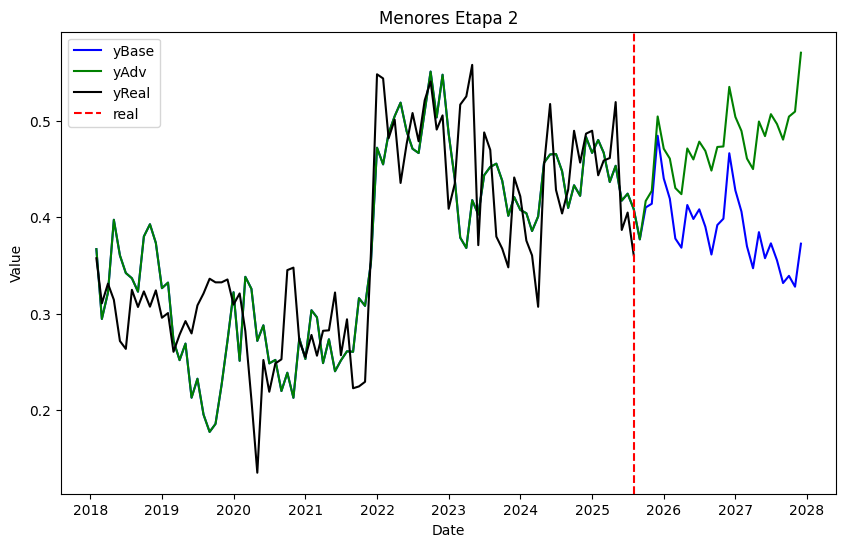

In [699]:
df_base_forecast, df_adv_forecast = functions.NP_model.run_model(model_attributes, future_regressor, basic, df_base, df_adv, added_events)

df_base_forecast.rename(columns={'yhat1':'y_Base'},inplace=True)
df_adv_forecast.rename(columns={'yhat1':'y_Adv'},inplace=True)

df_Estres= df_base_forecast.merge(df_adv_forecast[['ds','y_Adv']], left_on='ds', right_on='ds', how='outer')

# Extract 'ds', 'yhat1', and 'y_y' columns from the DataFrame
ds = df_Estres['ds']
yBase = df_Estres['y_Base']
yAdv = df_Estres['y_Adv']
yReal = df_Estres['y']

# Plot the data
fig = plt.figure(figsize=(10, 6))
plt.plot(ds, yBase, label='yBase', color='blue')
plt.plot(ds, yAdv, label='yAdv', color='green')
plt.plot(ds, yReal, label='yReal', color='black')
plt.axvline(x=basic.ds.max(), color='red', linestyle='--', label='real')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title(f'{segmento} Etapa {etapa}')
plt.legend()
plt.show()

In [701]:
resultados = df_Estres[['ds','y_Base','y_Adv']].iloc[-forecast:]
resultados.head()

,ds,y_Base,y_Adv
91,2025-09-01,0.377177,0.377177
92,2025-10-01,0.410235,0.416903
93,2025-11-01,0.414097,0.427433
94,2025-12-01,0.484521,0.504524
95,2026-01-01,0.440315,0.471101


## Guardado de resultados

In [672]:
fig.savefig(f'{functions.settings.current_wd}/Proyectos/{banco}{functions.settings.project_name}/Output/Forecast.png', dpi=fig.dpi)
resultados.to_csv(f'{functions.settings.current_wd}/Proyectos/{banco}{functions.settings.project_name}/Output/resultados.csv', index=False)
resultados.to_csv('s3://boi-banregio/datalake/data/InteligenciaRiesgos/brm17632/RiesgoCredito/ESC/'+anio+'/'+tetra+'/'+banco+segmento+'/Etapa'+str(etapa)+'.csv', index=False)
functions.NP_model.save_regressors('future_regressors', future_regressor, banco)

Los regresores seleccionados se han guardado correctamente


## Resúmen de datos

In [703]:
ConsumoE1= pd.read_csv('s3://boi-banregio/datalake/data/InteligenciaRiesgos/brm17632/RiesgoCredito/ESC/'+anio+'/'+tetra+'/'+banco+'Consumo/Etapa1.csv')
ConsumoE1.head()

,ds,y_Base,y_Adv
0,2025-09-01,0.013518,0.013518
1,2025-10-01,0.013041,0.013869
2,2025-11-01,0.011561,0.013216
3,2025-12-01,0.012041,0.014524
4,2026-01-01,0.010299,0.013366


In [704]:
ConsumoE1.rename(columns={'y_Base':'Consumo_E1_Base','y_Adv':'Consumo_E1_Adv'},inplace=True)
ConsumoE1.head() 

,ds,Consumo_E1_Base,Consumo_E1_Adv
0,2025-09-01,0.013518,0.013518
1,2025-10-01,0.013041,0.013869
2,2025-11-01,0.011561,0.013216
3,2025-12-01,0.012041,0.014524
4,2026-01-01,0.010299,0.013366


In [705]:
ConsumoE2= pd.read_csv('s3://boi-banregio/datalake/data/InteligenciaRiesgos/brm17632/RiesgoCredito/ESC/'+anio+'/'+tetra+'/'+banco+'Consumo/Etapa2.csv')
ConsumoE2.head()

,ds,y_Base,y_Adv
0,2025-09-01,0.662323,0.662323
1,2025-10-01,0.658045,0.669667
2,2025-11-01,0.665915,0.689158
3,2025-12-01,0.677953,0.712818
4,2026-01-01,0.685449,0.726073


In [706]:
ConsumoE2.rename(columns={'y_Base':'Consumo_E2_Base','y_Adv':'Consumo_E2_Adv'},inplace=True)
ConsumoE2.head()

,ds,Consumo_E2_Base,Consumo_E2_Adv
0,2025-09-01,0.662323,0.662323
1,2025-10-01,0.658045,0.669667
2,2025-11-01,0.665915,0.689158
3,2025-12-01,0.677953,0.712818
4,2026-01-01,0.685449,0.726073


In [707]:
MenoresE1=pd.read_csv('s3://boi-banregio/datalake/data/InteligenciaRiesgos/brm17632/RiesgoCredito/ESC/'+anio+'/'+tetra+'/'+banco+'Menores/Etapa1.csv')
MenoresE1.head()

,ds,y_Base,y_Adv
0,2025-09-01,0.023711,0.023711
1,2025-10-01,0.023097,0.023813
2,2025-11-01,0.022419,0.023851
3,2025-12-01,0.021173,0.023321
4,2026-01-01,0.020295,0.024357


In [708]:
MenoresE1.rename(columns={'y_Base':'Menores_E1_Base','y_Adv':'Menores_E1_Adv'},inplace=True)
MenoresE1.head()

,ds,Menores_E1_Base,Menores_E1_Adv
0,2025-09-01,0.023711,0.023711
1,2025-10-01,0.023097,0.023813
2,2025-11-01,0.022419,0.023851
3,2025-12-01,0.021173,0.023321
4,2026-01-01,0.020295,0.024357


In [709]:
MenoresE2=pd.read_csv('s3://boi-banregio/datalake/data/InteligenciaRiesgos/brm17632/RiesgoCredito/ESC/'+anio+'/'+tetra+'/'+banco+'Menores/Etapa2.csv')
MenoresE2.head()

,ds,y_Base,y_Adv
0,2025-09-01,0.377177,0.377177
1,2025-10-01,0.410235,0.416903
2,2025-11-01,0.414097,0.427433
3,2025-12-01,0.484521,0.504524
4,2026-01-01,0.440315,0.471101


In [710]:
MenoresE2.rename(columns={'y_Base':'Menores_E2_Base','y_Adv':'Menores_E2_Adv'},inplace=True)
MenoresE2.head()

,ds,Menores_E2_Base,Menores_E2_Adv
0,2025-09-01,0.377177,0.377177
1,2025-10-01,0.410235,0.416903
2,2025-11-01,0.414097,0.427433
3,2025-12-01,0.484521,0.504524
4,2026-01-01,0.440315,0.471101


In [711]:
CorporativosE1=pd.read_csv('s3://boi-banregio/datalake/data/InteligenciaRiesgos/brm17632/RiesgoCredito/ESC/'+anio+'/'+tetra+'/'+banco+'Corporativos/Etapa1.csv')
CorporativosE1.head()

,ds,y_Base,y_Adv
0,2025-09-01,0.013518,0.013518
1,2025-10-01,0.013041,0.013869
2,2025-11-01,0.011561,0.013216
3,2025-12-01,0.012041,0.014524
4,2026-01-01,0.010299,0.013366


In [712]:
CorporativosE1.rename(columns={'y_Base':'Corporativos_E1_Base','y_Adv':'Corporativos_E1_Adv'},inplace=True)
CorporativosE1.head()

,ds,Corporativos_E1_Base,Corporativos_E1_Adv
0,2025-09-01,0.013518,0.013518
1,2025-10-01,0.013041,0.013869
2,2025-11-01,0.011561,0.013216
3,2025-12-01,0.012041,0.014524
4,2026-01-01,0.010299,0.013366


In [713]:
CorporativosE2=pd.read_csv('s3://boi-banregio/datalake/data/InteligenciaRiesgos/brm17632/RiesgoCredito/ESC/'+anio+'/'+tetra+'/'+banco+'Corporativos/Etapa2.csv')
CorporativosE2.head()

,ds,y_Base,y_Adv
0,2025-09-01,0.223540,0.223540
1,2025-10-01,0.218088,0.243859
2,2025-11-01,0.167951,0.219493
3,2025-12-01,0.148318,0.225631
4,2026-01-01,0.168414,0.253170


In [714]:
CorporativosE2.rename(columns={'y_Base':'Corporativos_E2_Base','y_Adv':'Corporativos_E2_Adv'},inplace=True)
CorporativosE2.head()

,ds,Corporativos_E2_Base,Corporativos_E2_Adv
0,2025-09-01,0.223540,0.223540
1,2025-10-01,0.218088,0.243859
2,2025-11-01,0.167951,0.219493
3,2025-12-01,0.148318,0.225631
4,2026-01-01,0.168414,0.253170


In [715]:
HipotecarioE1=pd.read_csv('s3://boi-banregio/datalake/data/InteligenciaRiesgos/brm17632/RiesgoCredito/ESC/'+anio+'/'+tetra+'/'+banco+'Hipotecario/Etapa1.csv')
HipotecarioE1.head()

,ds,y_Base,y_Adv
0,2025-09-01,0.021865,0.021865
1,2025-10-01,0.021135,0.022109
2,2025-11-01,0.022132,0.024080
3,2025-12-01,0.021640,0.024562
4,2026-01-01,0.021272,0.024853


In [716]:
HipotecarioE1.rename(columns={'y_Base':'Hipotecario_E1_Base','y_Adv':'Hipotecario_E1_Adv'},inplace=True)
HipotecarioE1.head()

,ds,Hipotecario_E1_Base,Hipotecario_E1_Adv
0,2025-09-01,0.021865,0.021865
1,2025-10-01,0.021135,0.022109
2,2025-11-01,0.022132,0.024080
3,2025-12-01,0.021640,0.024562
4,2026-01-01,0.021272,0.024853


In [717]:
HipotecarioE2=pd.read_csv('s3://boi-banregio/datalake/data/InteligenciaRiesgos/brm17632/RiesgoCredito/ESC/'+anio+'/'+tetra+'/'+banco+'Hipotecario/Etapa2.csv')
HipotecarioE2.head()

,ds,y_Base,y_Adv
0,2025-09-01,0.554340,0.554340
1,2025-10-01,0.552595,0.556892
2,2025-11-01,0.556316,0.564909
3,2025-12-01,0.550062,0.562952
4,2026-01-01,0.536567,0.559283


In [718]:
HipotecarioE2.rename(columns={'y_Base':'Hipotecario_E2_Base','y_Adv':'Hipotecario_E2_Adv'},inplace=True)
HipotecarioE2.head()

,ds,Hipotecario_E2_Base,Hipotecario_E2_Adv
0,2025-09-01,0.554340,0.554340
1,2025-10-01,0.552595,0.556892
2,2025-11-01,0.556316,0.564909
3,2025-12-01,0.550062,0.562952
4,2026-01-01,0.536567,0.559283


In [719]:
PIs_Proyectadas= ConsumoE1.merge(ConsumoE2,left_on='ds',right_on='ds',how='left').\
                merge(MenoresE1, left_on='ds',right_on='ds',how='left').merge(MenoresE2,left_on='ds',right_on='ds',how='left').\
                merge(CorporativosE1,left_on='ds',right_on='ds',how='left').merge(CorporativosE2,left_on='ds',right_on='ds',how='left').\
                merge(HipotecarioE1,left_on='ds',right_on='ds',how='left').merge(HipotecarioE2,left_on='ds',right_on='ds',how='left')
PIs_Proyectadas.tail()

,ds,Consumo_E1_Base,Consumo_E1_Adv,Consumo_E2_Base,Consumo_E2_Adv,Menores_E1_Base,Menores_E1_Adv,Menores_E2_Base,Menores_E2_Adv,Corporativos_E1_Base,Corporativos_E1_Adv,Corporativos_E2_Base,Corporativos_E2_Adv,Hipotecario_E1_Base,Hipotecario_E1_Adv,Hipotecario_E2_Base,Hipotecario_E2_Adv
23,2027-08-01,0.003781,0.011352,0.636127,0.759495,0.019703,0.027408,0.355493,0.496693,0.003781,0.011352,0.183961,0.233956,0.018190,0.022630,0.558562,0.572169
24,2027-09-01,0.002451,0.009930,0.636117,0.766656,0.020930,0.028296,0.331923,0.480490,0.002451,0.009930,0.205482,0.252422,0.018384,0.022810,0.580586,0.591848
25,2027-10-01,0.003647,0.010983,0.618816,0.755035,0.020724,0.027881,0.339382,0.504374,0.003647,0.010983,0.195226,0.240730,0.018014,0.022327,0.583753,0.594573
26,2027-11-01,0.002449,0.009642,0.618243,0.760142,0.020539,0.027487,0.328150,0.509566,0.002449,0.009642,0.148682,0.192748,0.018884,0.023086,0.594028,0.604406
27,2027-12-01,0.004579,0.011629,0.617048,0.764625,0.019708,0.026447,0.372718,0.570559,0.004579,0.011629,0.122500,0.165128,0.018792,0.022882,0.593001,0.602937


In [720]:
PIs_Proyectadas=PIs_Proyectadas[['ds','Corporativos_E1_Base','Menores_E1_Base', 'Consumo_E1_Base', 'Hipotecario_E1_Base',
                                 'Corporativos_E2_Base','Menores_E2_Base', 'Consumo_E2_Base', 'Hipotecario_E2_Base', 
                                 'Corporativos_E1_Adv','Menores_E1_Adv', 'Consumo_E1_Adv', 'Hipotecario_E1_Adv',
                                 'Corporativos_E2_Adv', 'Menores_E2_Adv', 'Consumo_E2_Adv', 'Hipotecario_E2_Adv']]
PIs_Proyectadas.head()

,ds,Corporativos_E1_Base,Menores_E1_Base,Consumo_E1_Base,Hipotecario_E1_Base,Corporativos_E2_Base,Menores_E2_Base,Consumo_E2_Base,Hipotecario_E2_Base,Corporativos_E1_Adv,Menores_E1_Adv,Consumo_E1_Adv,Hipotecario_E1_Adv,Corporativos_E2_Adv,Menores_E2_Adv,Consumo_E2_Adv,Hipotecario_E2_Adv
0,2025-09-01,0.013518,0.023711,0.013518,0.021865,0.223540,0.377177,0.662323,0.554340,0.013518,0.023711,0.013518,0.021865,0.223540,0.377177,0.662323,0.554340
1,2025-10-01,0.013041,0.023097,0.013041,0.021135,0.218088,0.410235,0.658045,0.552595,0.013869,0.023813,0.013869,0.022109,0.243859,0.416903,0.669667,0.556892
2,2025-11-01,0.011561,0.022419,0.011561,0.022132,0.167951,0.414097,0.665915,0.556316,0.013216,0.023851,0.013216,0.024080,0.219493,0.427433,0.689158,0.564909
3,2025-12-01,0.012041,0.021173,0.012041,0.021640,0.148318,0.484521,0.677953,0.550062,0.014524,0.023321,0.014524,0.024562,0.225631,0.504524,0.712818,0.562952
4,2026-01-01,0.010299,0.020295,0.010299,0.021272,0.168414,0.440315,0.685449,0.536567,0.013366,0.024357,0.013366,0.024853,0.253170,0.471101,0.726073,0.559283


In [721]:
#df_f solo los casos que se utilizan
PIs_Proyectadas.to_csv('s3://boi-banregio/datalake/data/InteligenciaRiesgos/brm17632/RiesgoCredito/ESC/'+anio+'/'+tetra+'/'+banco+'PIs_Proyectadas.csv', index=False)

In [723]:
PIs_Proyectadas.head()

,ds,Corporativos_E1_Base,Menores_E1_Base,Consumo_E1_Base,Hipotecario_E1_Base,Corporativos_E2_Base,Menores_E2_Base,Consumo_E2_Base,Hipotecario_E2_Base,Corporativos_E1_Adv,Menores_E1_Adv,Consumo_E1_Adv,Hipotecario_E1_Adv,Corporativos_E2_Adv,Menores_E2_Adv,Consumo_E2_Adv,Hipotecario_E2_Adv
0,2025-09-01,0.013518,0.023711,0.013518,0.021865,0.223540,0.377177,0.662323,0.554340,0.013518,0.023711,0.013518,0.021865,0.223540,0.377177,0.662323,0.554340
1,2025-10-01,0.013041,0.023097,0.013041,0.021135,0.218088,0.410235,0.658045,0.552595,0.013869,0.023813,0.013869,0.022109,0.243859,0.416903,0.669667,0.556892
2,2025-11-01,0.011561,0.022419,0.011561,0.022132,0.167951,0.414097,0.665915,0.556316,0.013216,0.023851,0.013216,0.024080,0.219493,0.427433,0.689158,0.564909
3,2025-12-01,0.012041,0.021173,0.012041,0.021640,0.148318,0.484521,0.677953,0.550062,0.014524,0.023321,0.014524,0.024562,0.225631,0.504524,0.712818,0.562952
4,2026-01-01,0.010299,0.020295,0.010299,0.021272,0.168414,0.440315,0.685449,0.536567,0.013366,0.024357,0.013366,0.024853,0.253170,0.471101,0.726073,0.559283
